In [6]:
from base64 import b64decode
import itertools
import math

from elasticsearch import Elasticsearch, helpers as es_helpers
import matplotlib.pyplot as plt
import scipy.stats as stat
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from tqdm import tqdm

from warc_analysis.config import get_config

sns.set_style('ticks')
plt.rcParams['figure.dpi'] = 98
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
plt.rcParams['font.family'] = 'sans-serif'

In [7]:
MAX_AFFILIATE_LINKS = 40
MIN_WORDS = 500

def load_docs(index, keep_cols=None,
              max_rank=20, max_affiliate_links=MAX_AFFILIATE_LINKS, min_words=MIN_WORDS):
    client = Elasticsearch(**get_config()['elasticsearch'])
    keep_cols = set(keep_cols) if keep_cols else set()
    
    docs = []
    doc_ids = []
    for doc in tqdm(es_helpers.scan(client, index=index), desc='Reading metadata', unit=' docs'):
        if doc['_source']['affiliate_links'] > max_affiliate_links or doc['_source']['num_words'] < min_words:
            continue
    
        d = {k: v for k, v in doc['_source'].items() if type(v) in [int, float, bool] or k in keep_cols}
        doc_id = doc['_id']
        if doc_id.count(':') == 1:
            q, r = doc_id.split(':')
            if int(r) >= max_rank:
                continue
            doc_id = f'q-{q}', int(r)
            
        d['non_affiliate_links'] = d['links'] - d['affiliate_links']
        d['has_affiliate_links'] = d['affiliate_links'] > 0
        d.update({f'freq_{i}': v for i, v in enumerate(np.frombuffer(
            b64decode(doc['_source']['word_freq_vec']), dtype=np.uint8).tolist())})
        
        doc_ids.append(doc_id)
        docs.append(d)
    
    if doc_ids and type(doc_ids[0]) is tuple:
        doc_ids = pd.MultiIndex.from_tuples(doc_ids, names=['query', 'rank'])
    return pd.DataFrame.from_records(docs, index=doc_ids).sort_index().fillna(0)

In [8]:
INPUT_INDEX = 'affiliate_se_stats_clueweb22_chatnoir'
# INPUT_INDEX = 'affiliate_cw_stats_22'
# INPUT_INDEX = 'affiliate_search_engine_stats_bing_2022_10_28'

docs = load_docs(INPUT_INDEX)

Reading metadata: 181875 docs [00:33, 5482.35 docs/s]


In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost.sklearn import XGBRegressor, XGBClassifier

DEPENDENT_VARIABLE = 'affiliate_links'
RESAMPLE = True
STRATIFY_BY = DEPENDENT_VARIABLE
STRATIFY_BY = None
DROP_FREQS = False

def drop_columns(df):
    """
    Drop telltale columns from dataframe.
    """
    dc = {DEPENDENT_VARIABLE, 'src_offset'}
    if 'links' in DEPENDENT_VARIABLE or 'affiliate' in DEPENDENT_VARIABLE or DEPENDENT_VARIABLE in ['fwr', 'ttr']:
        dc.update(c for c in df.columns
                  if 'links' in c or 'anchor' in c or c.startswith('affiliate_')
                  or c in ['has_affiliate_links', 'non_affiliate_links', 'self_link_ratio'])
        # if DEPENDENT_VARIABLE != 'has_affiliate_links':
        dc.update(c for c in df.columns if c.endswith('num_words') or c.endswith('num_chars'))
    if DEPENDENT_VARIABLE in ['fwr', 'ttr', 'flesch_ease', 'flesch_grade']:
        dc.update(c for c in df.columns if 'flesch' in c or 'fwr' in c or 'ttr' in c)
        
    if DROP_FREQS:
        dc.update(c for c in df.columns if c.startswith('freq_'))
        
    return df.drop(columns=dc)

# Downsample non-affiliate pages
docs_with_affiliates = docs[docs['affiliate_links'] > 0]
docs_without_affiliates = docs[docs['affiliate_links'] == 0]
if RESAMPLE and len(docs_without_affiliates) > len(docs_with_affiliates):
    docs_without_affiliates = resample(docs_without_affiliates, replace=False, n_samples=docs_with_affiliates.shape[0], random_state=0)
docs_resampled = pd.concat([docs_with_affiliates, docs_without_affiliates])

docs_train, docs_test = train_test_split(docs_resampled,
                                         train_size=0.8,
                                         shuffle=True,
                                         random_state=123,
                                         stratify=docs_resampled[STRATIFY_BY] if STRATIFY_BY else None)
del docs_resampled, docs_with_affiliates, docs_without_affiliates

scaler = preprocessing.StandardScaler().fit(docs_train)
docs_train_scaled = pd.DataFrame(scaler.transform(docs_train), columns=docs_train.columns, index=docs_train.index)
docs_test_scaled = pd.DataFrame(scaler.transform(docs_test), columns=docs_test.columns, index=docs_test.index)

X_train = drop_columns(docs_train_scaled)
y_train = docs_train[DEPENDENT_VARIABLE]
X_test = drop_columns(docs_test_scaled)

In [10]:
# from sklearn.model_selection import GridSearchCV
# 
# grid = GridSearchCV(XGBRegressor(), dict(
#     learning_rate=[0.01, 0.1, 0.5, 1.0],
#     booster=['gbtree', 'dart'],
#     reg_lambda=[1.0, 1.2, 1.5]), cv=10, n_jobs=1, refit=False, verbose=2)
# grid.fit(X_train, y_train)
# print('Best parameters:', grid.best_params_)

In [11]:
# best_params = grid.best_params_
best_params = {'booster': 'gbtree', 'learning_rate': 0.5, 'objective': 'reg:squarederror', 'reg_lambda': 1.0}
# best_params = {'booster': 'dart', 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 150, 'reg_lambda': 1.5}
if y_train.dtypes == 'bool':
    clf = XGBClassifier(**best_params)
else:
    clf = XGBRegressor(**best_params)
clf.fit(X_train, y_train)


if hasattr(clf, 'coef_'):
    feature_argsort = np.argsort(np.abs(clf.coef_))[::-1]
    print('Feature importance:', [X_train.columns[i] for i in feature_argsort])
else:
    print('Features used:', list(X_train.columns))

Features used: ['url_path_chars', 'url_path_depth', 'url_hyphen_path_ratio', 'url_path_digits', 'title_chars', 'is_review', 'num_h1', 'num_h2', 'num_img', 'ttr', 'fwr', 'meta_ttr', 'meta_fwr', 'h1_ttr', 'h1_fwr', 'img_ttr', 'img_fwr', 'a_ttr', 'a_fwr', 'num_meta_keywords', 'ph_ratio', 'heading_keyword_overlap', 'meta_keyword_overlap', 'num_ldjson', 'has_og', 'has_bread', 'flesch_ease', 'flesch_grade', 'freq_0', 'freq_1', 'freq_2', 'freq_3', 'freq_4', 'freq_5', 'freq_6', 'freq_7', 'freq_8', 'freq_9', 'freq_10', 'freq_11', 'freq_12', 'freq_13', 'freq_14', 'freq_15', 'freq_16', 'freq_17', 'freq_18', 'freq_19', 'freq_20', 'freq_21', 'freq_22', 'freq_23', 'freq_24', 'freq_25', 'freq_26', 'freq_27', 'freq_28', 'freq_29', 'freq_30', 'freq_31', 'freq_32', 'freq_33', 'freq_34', 'freq_35', 'freq_36', 'freq_37', 'freq_38', 'freq_39', 'freq_40', 'freq_41', 'freq_42', 'freq_43', 'freq_44', 'freq_45', 'freq_46', 'freq_47', 'freq_48', 'freq_49', 'freq_50', 'freq_51', 'freq_52', 'freq_53', 'freq_54', 

Dependent variable: affiliate_links

r = 0.74
R² = 0.54
MSE = 53.463


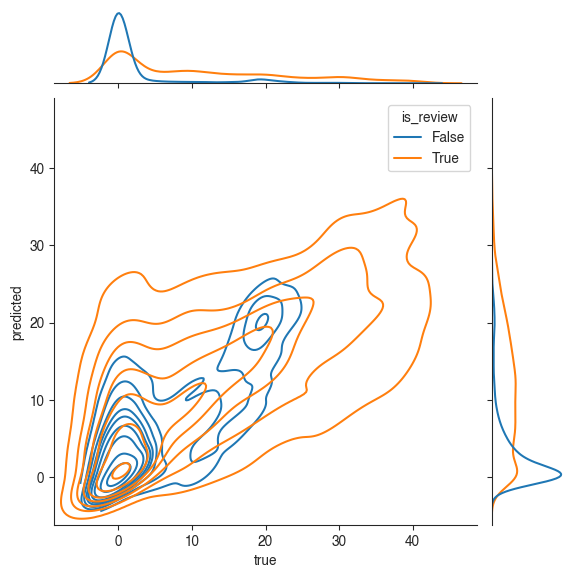

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
    f1_score, mean_squared_error, precision_score, recall_score

y_test = docs_test[DEPENDENT_VARIABLE]
y_pred = np.clip(clf.predict(X_test), 0, None)
# if y_test.dtypes == 'int64':
#     y_pred = y_pred.round(0).astype(int)

def cohens_d(x1, x2):
    s1, s2 = x1.var(ddof=1), x2.var(ddof=1)
    s = np.sqrt(((len(x1) - 1) * s1 + (len(x2) - 1) * s2) / (len(x1) + len(x2) - 2))
    return (x1.mean() - x2.mean()) / s

print(f'Dependent variable: {DEPENDENT_VARIABLE}\n')

if isinstance(clf, XGBClassifier):
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('Prec: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Rec: {:.2f}'.format(recall_score(y_test, y_pred)))

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf.classes_).plot(cmap='Blues')
else:
    print('r = {:.2f}'.format(stat.pearsonr(y_test, y_pred).statistic))
    print('R² = {:.2f}'.format(r2_score(y_test, y_pred)))
    print('MSE = {:.3f}'.format(mean_squared_error(y_test, y_pred)))
    scatter_data = pd.DataFrame({'true': y_test, 'predicted': y_pred})

    # scatter_data = scatter_data[(y_test >= 0) & (y_pred >= 0)]
    sns.jointplot(scatter_data, x='true', y='predicted', kind='kde', hue=docs_test['is_review']);#, scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})

In [14]:
pair_groups = ['has_affiliate_links', 'affiliate_links', 'is_review', 'ttr', 'fwr', 'ph_ratio', 'heading_keyword_overlap', 'flesch_ease']

print('Group differences:')
for g1 in pair_groups:
    for g2 in ['is_review', 'has_affiliate_links']:
        if g1 == g2 or docs_test[g1].dtypes == 'bool':
            continue
        print(f'\n{g1} by {g2}:')
        df1 = docs_test[g1][docs_test[g2]]
        df2 = docs_test[g1][~docs_test[g2]]
        
        t_test = stat.ttest_ind(df1, df2)
        print('t = {:.2f}, p = {:.2g}, d = {:.3f}'.format(t_test.statistic, t_test.pvalue, cohens_d(df1, df2)))
        mwu_test = stat.mannwhitneyu(df1, df2)#mwu_test.statistic / (len(df1) * len(df2)), stat.spearmanr(df1, df2))
        print('U = {:.0f}, p = {:.2g}, r = {:.3f}, r_biserial = {:.3f}'.format(
            mwu_test.statistic,
            mwu_test.pvalue,
            stat.norm.ppf(mwu_test.pvalue) / np.sqrt(len(df1) + len(df2)),
            (2 * mwu_test.statistic) / (len(df1) * len(df2)) - 1))

Group differences:

affiliate_links by is_review:
t = 33.72, p = 1.1e-229, d = 0.866
U = 7353042, p = 2.3e-298, r = -0.461, r_biserial = 0.512

affiliate_links by has_affiliate_links:
t = 84.22, p = 0, d = 2.102
U = 10303904, p = 0, r = -inf, r_biserial = 1.000

ttr by is_review:
t = -19.13, p = 2.4e-79, d = -0.491
U = 3451015, p = 2.1e-85, r = -0.244, r_biserial = -0.290

ttr by has_affiliate_links:
t = -16.86, p = 2e-62, d = -0.421
U = 3812948, p = 1.1e-72, r = -0.225, r_biserial = -0.260

fwr by is_review:
t = 17.56, p = 1.7e-67, d = 0.451
U = 5922410, p = 1e-48, r = -0.182, r_biserial = 0.218

fwr by has_affiliate_links:
t = 29.34, p = 1.2e-177, d = 0.732
U = 7065230, p = 2.1e-146, r = -0.321, r_biserial = 0.371

ph_ratio by is_review:
t = -6.41, p = 1.6e-10, d = -0.165
U = 4851363, p = 0.86, r = 0.014, r_biserial = -0.003

ph_ratio by has_affiliate_links:
t = 3.66, p = 0.00026, d = 0.091
U = 6013758, p = 3.8e-31, r = -0.144, r_biserial = 0.167

heading_keyword_overlap by is_review

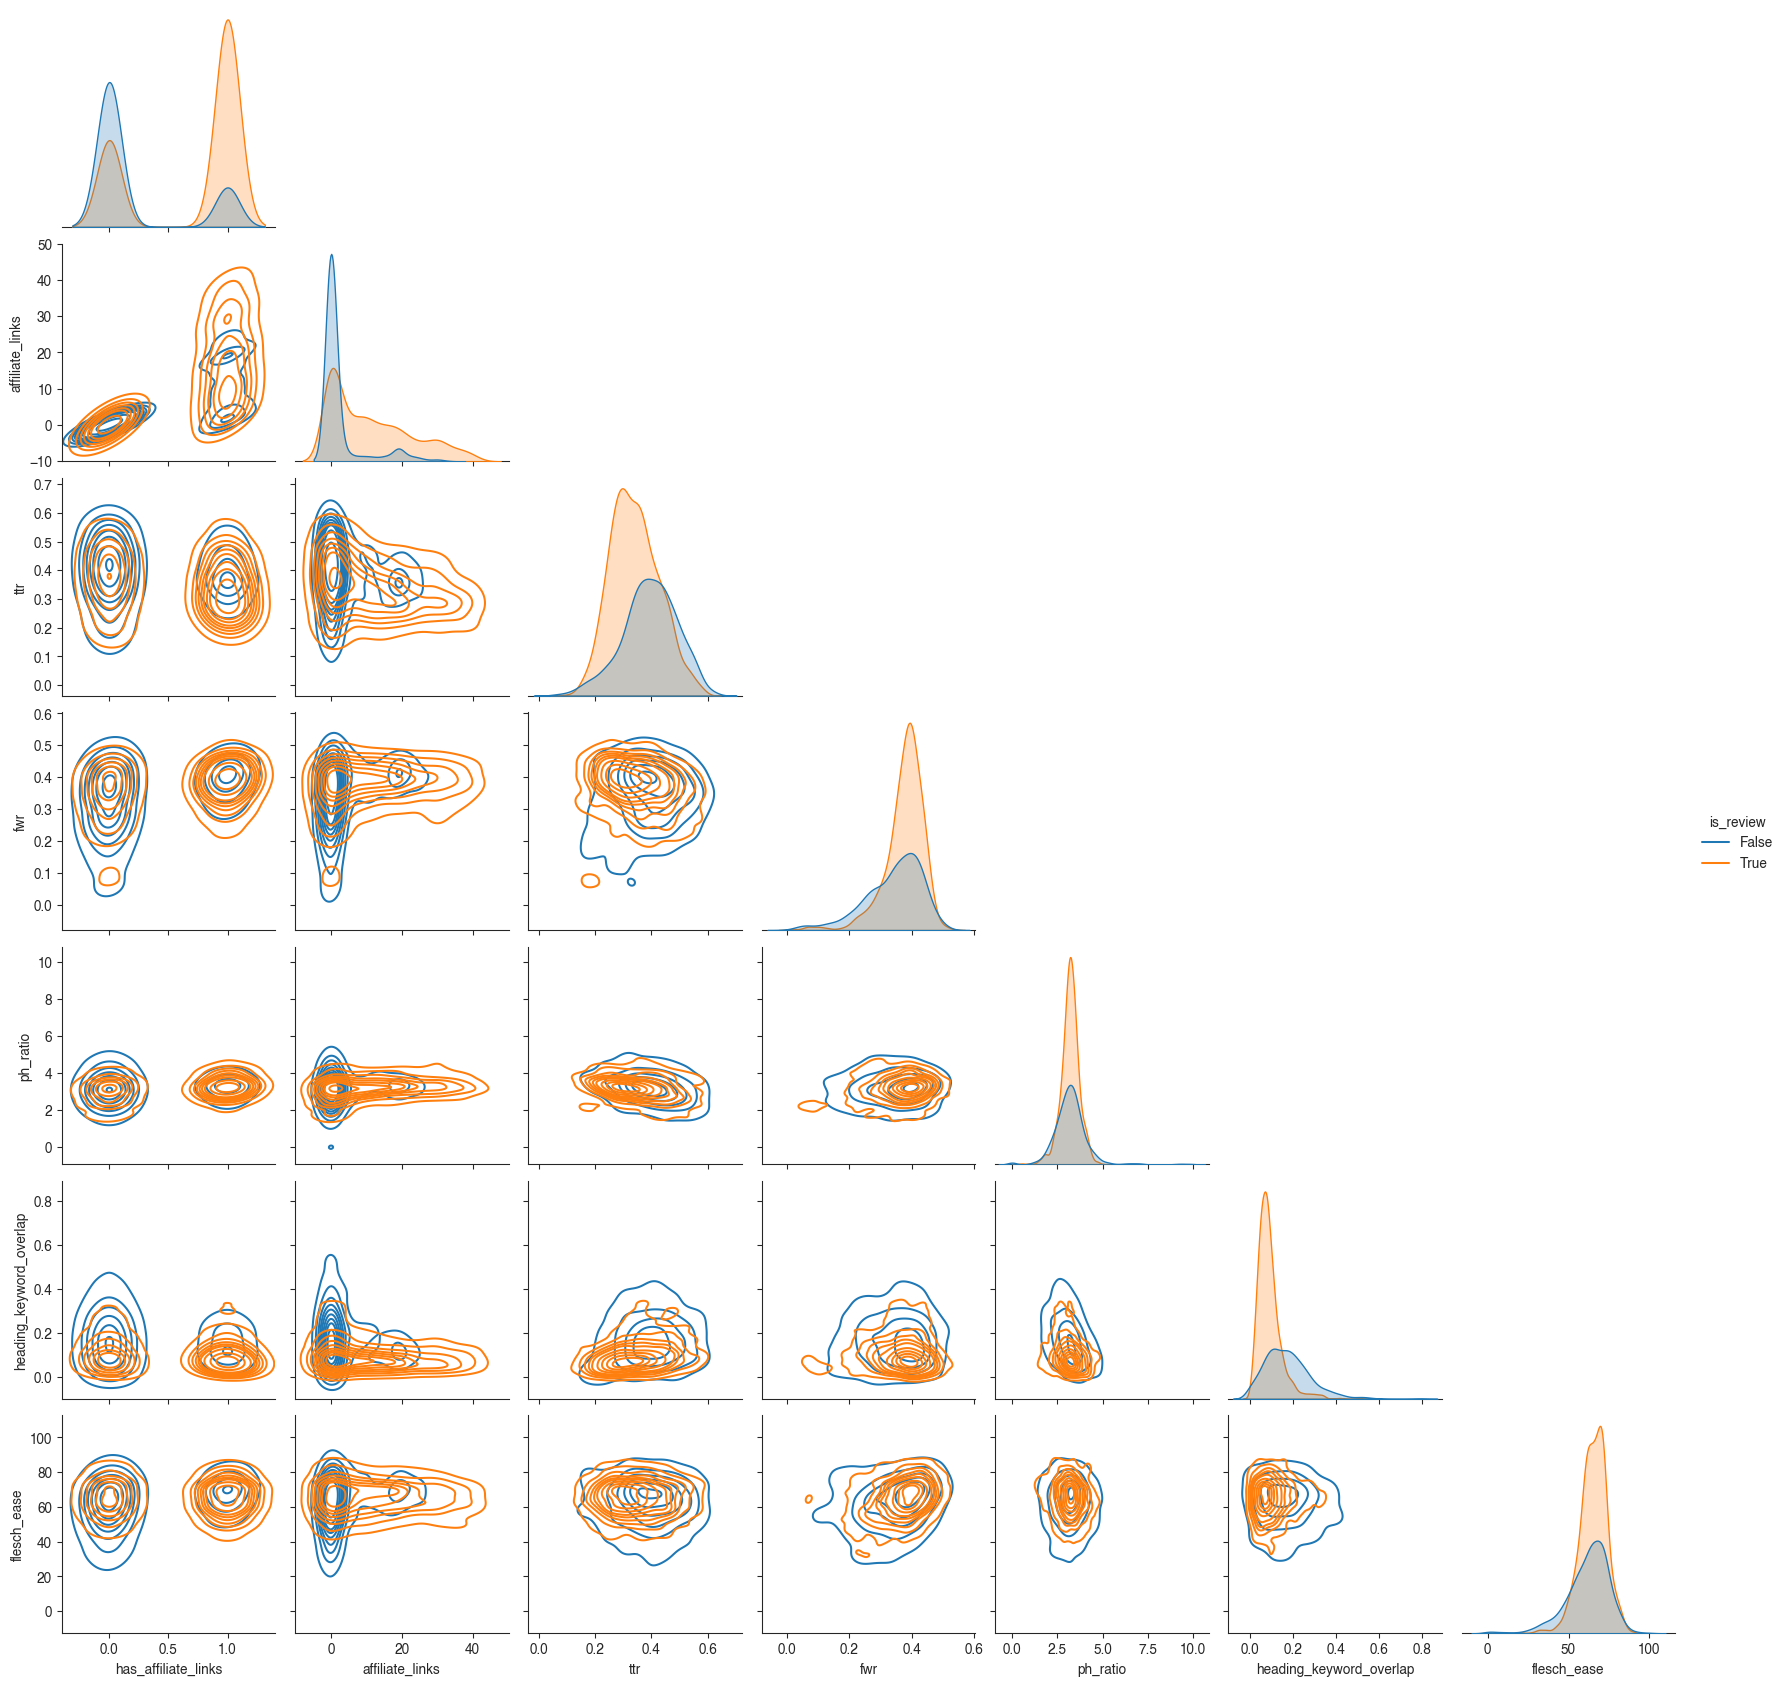

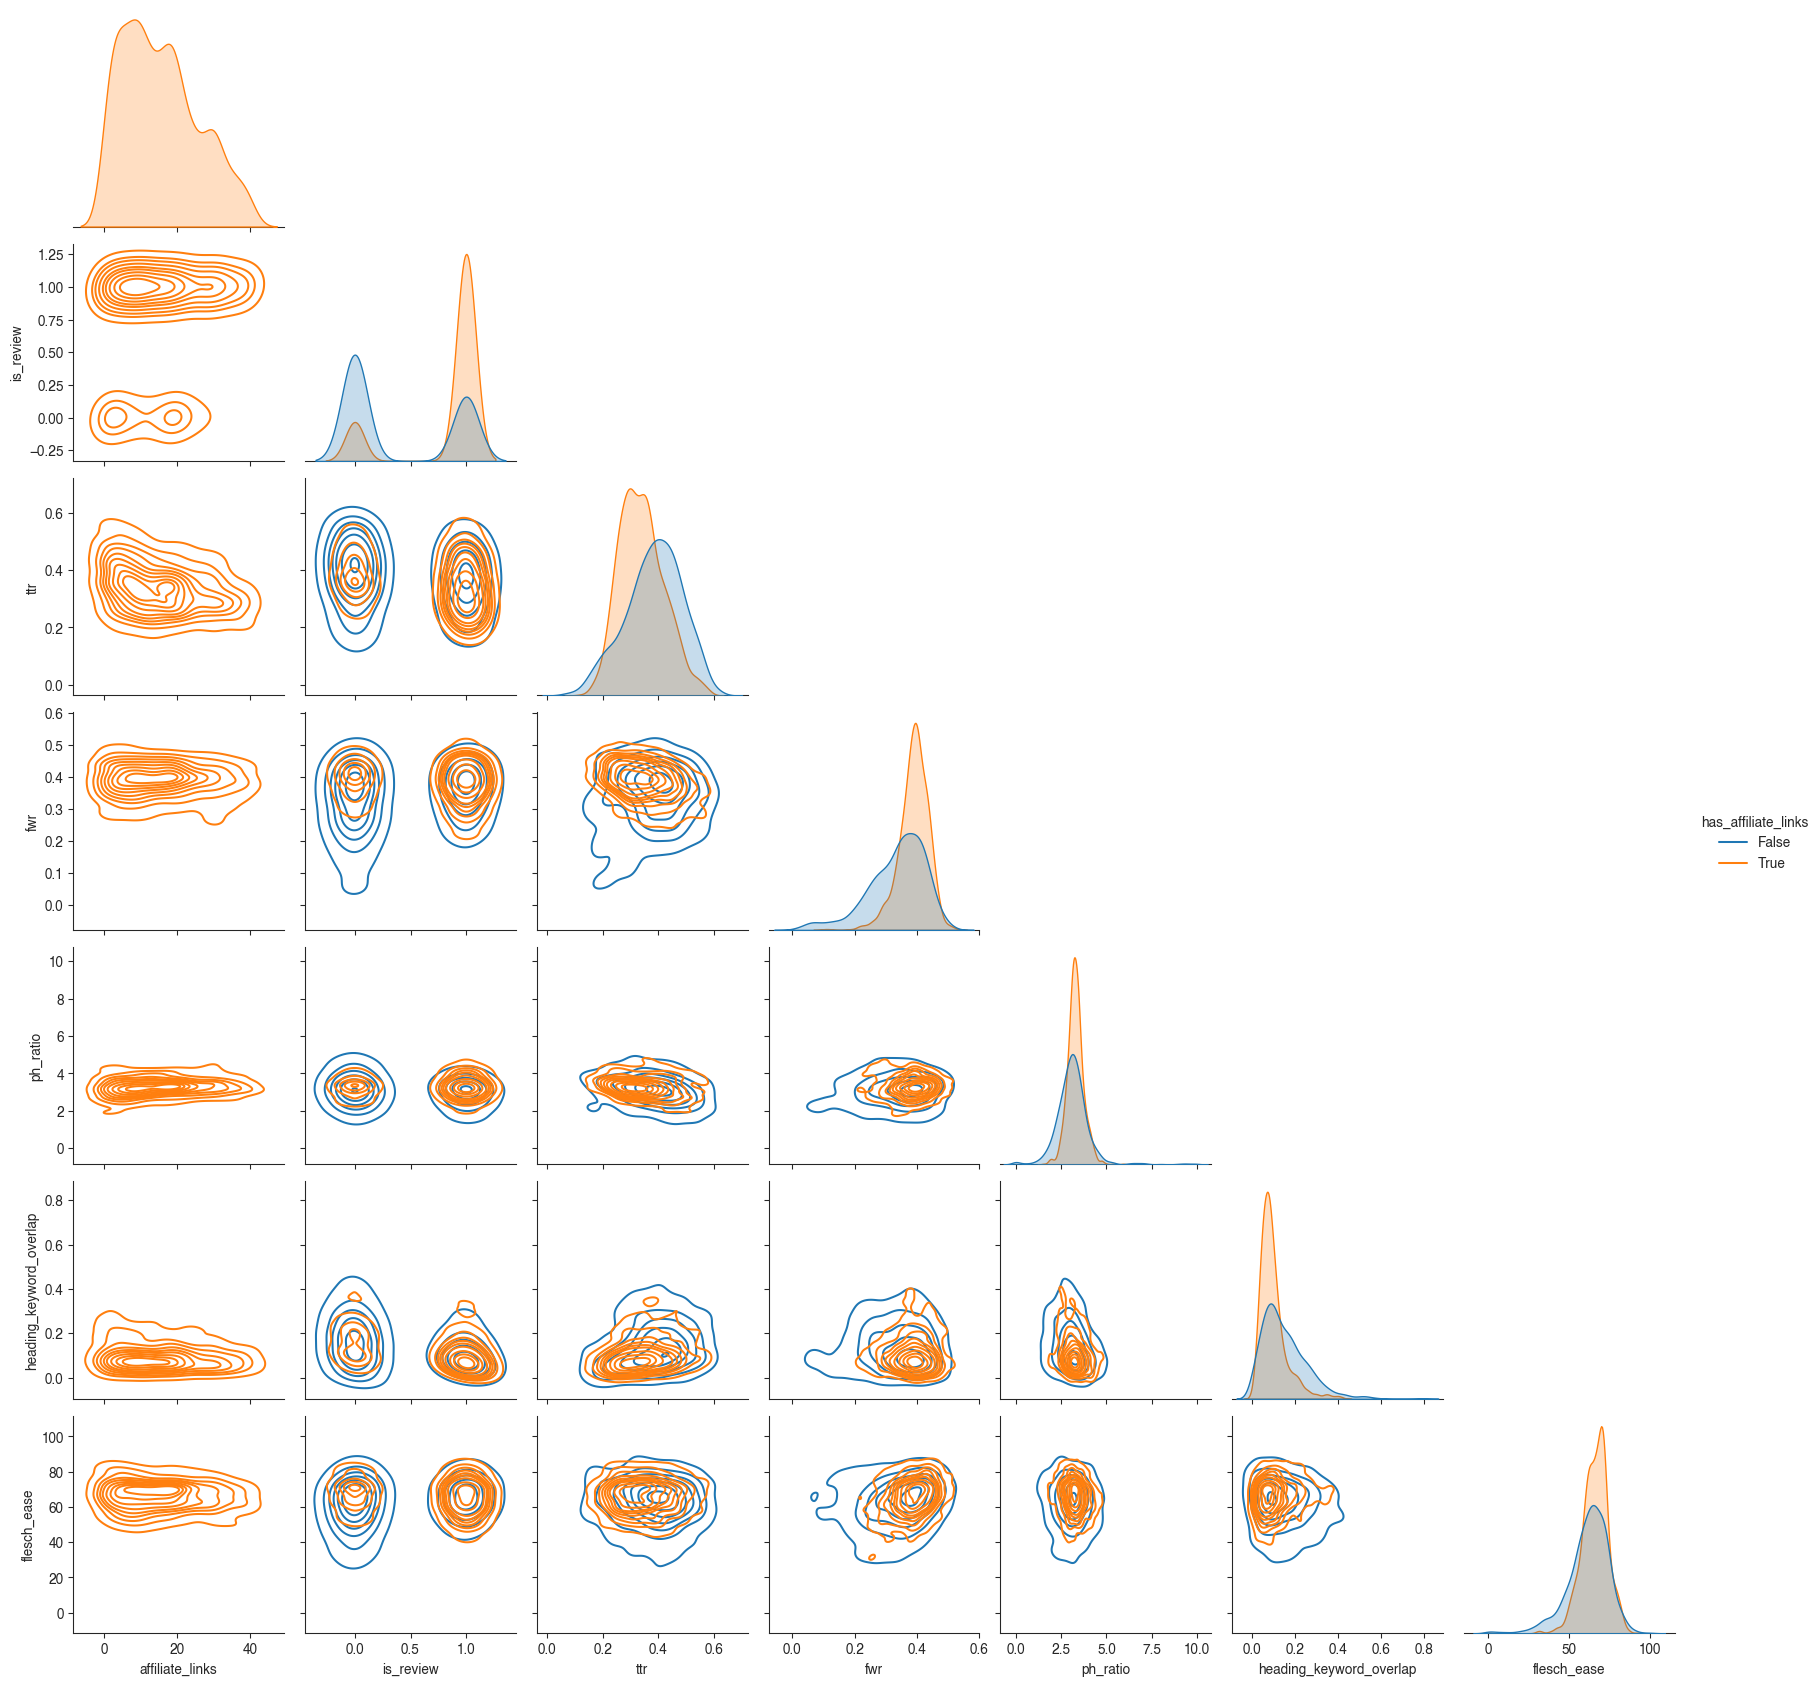

In [15]:
df = docs_train.loc[:, pair_groups].sample(2500, random_state=42)
sns.pairplot(df, hue='is_review', kind='kde', corner=True)#, plot_kws={'alpha': 0.3, 's': 15})
sns.pairplot(df, hue='has_affiliate_links', kind='kde', corner=True);#, plot_kws={'alpha': 0.3, 's': 15});

In [16]:
# RANK_CORR_INDICES = [
#     'chatnoir_clueweb22',
#     'bing_2022_10_28',
#     'bing_2023_01_13',
#     'bing_2023_01_27',
#     'bing_2023_08_25',
#     'bing_2023_08_28',
#     'ddg_2022_08_26',
#     'ddg_2023_01_13',
# ]

# rank_corr_docs = []
# for i in RANK_CORR_INDICES:
#     rank_corr_docs.append(load_docs('affiliate_search_engine_stats_' + i, keep_cols=['url', 'public_suffix'], max_affiliate_links=1000, min_words=0)
#                           .filter(['url', 'public_suffix', 'affiliate_links', 'num_words']))


import hashlib
import json
import os
from urllib.parse import urlparse

from warc_analysis.process import PublicSuffixList

JSONL_BASEPATH = 'resources/affiliate-serp-crawls'
RANK_CUTOFF = 20

# RANK_CORR_CRAWLS = [
#     'clueweb22-chatnoir', 
#     '2023-01-13-bing',
#     '2023-02-10-bing',
#     '2023-04-25-bing',
#     '2023-06-06-bing',
#     '2023-08-25-bing',
#     '2023-08-28-bing',
#     '2023-01-13-ddg',
#     '2023-02-10-ddg',
#     '2023-04-25-ddg',
#     '2023-06-06-ddg',
#     '2023-08-25-ddg',
#     '2022-08-24-startpage',
#     '2022-10-26-startpage',
#     '2022-11-11-startpage',
#     '2022-12-19-startpage',
#     '2023-01-12-startpage',
#     '2023-02-10-startpage',
#     '2023-04-24-startpage',
#     '2023-06-06-startpage',
#     '2023-08-23-startpage',
# ]
# RANK_CORR_CRAWLS = sorted(d for d in os.listdir(JSONL_BASEPATH) if d.endswith('-startpage'))
RANK_CORR_CRAWLS = sorted(d for d in os.listdir(JSONL_BASEPATH) if d.endswith('-startpage') or d.endswith('-bing'))
# RANK_CORR_CRAWLS = sorted(d for d in os.listdir(JSONL_BASEPATH) if d.endswith('-bing'))
# RANK_CORR_CRAWLS = sorted(d for d in os.listdir(JSONL_BASEPATH) if d.endswith('-ddg'))

def _read_lines(dir):
    if os.path.isfile(os.path.join(dir, 'results.jsonl')):
        yield from open(os.path.join(dir, 'results.jsonl'), 'r')
    else:
        yield from open(os.path.join(dir, 'gpc', 'results.jsonl'), 'r')
        yield from open(os.path.join(dir, 'gpt', 'results.jsonl'), 'r')

rank_corr_docs = []
psl = PublicSuffixList()
for i in RANK_CORR_CRAWLS:
    lines = []
    q_dedup = set()
    for l in tqdm(_read_lines(os.path.join(JSONL_BASEPATH, i)), desc=f'Loading {i}', unit=' lines'):
        j = json.loads(l)
        q = 'q-' + hashlib.md5(j['query'].encode()).hexdigest()
        if q in q_dedup:
            continue
        q_dedup.add(q)
        
        for i, r in enumerate(j['results'][:RANK_CUTOFF]):
            lines.append(dict(
                query=q,
                rank=i,
                url=r['url'],
                public_suffix=psl.get_public_suffix(urlparse(r['url']).netloc)
            ))
    rank_corr_docs.append(pd.DataFrame(lines).set_index(['query', 'rank']))

Loading 2022-08-24-startpage: 7634 lines [00:03, 2417.34 lines/s]
Loading 2022-10-26-startpage: 7634 lines [00:03, 2496.65 lines/s]
Loading 2022-10-28-bing: 7392 lines [00:03, 2390.00 lines/s]
Loading 2022-11-11-startpage: 7392 lines [00:03, 2396.03 lines/s]
Loading 2022-11-25-startpage: 7392 lines [00:03, 2418.56 lines/s]
Loading 2022-12-19-startpage: 7391 lines [00:02, 2465.06 lines/s]
Loading 2023-01-12-startpage: 7392 lines [00:02, 2493.90 lines/s]
Loading 2023-01-13-bing: 7392 lines [00:03, 2439.13 lines/s]
Loading 2023-01-27-bing: 7392 lines [00:02, 2595.36 lines/s]
Loading 2023-01-27-startpage: 7392 lines [00:03, 2435.18 lines/s]
Loading 2023-02-10-bing: 7392 lines [00:03, 2418.91 lines/s]
Loading 2023-02-10-startpage: 7392 lines [00:03, 2425.76 lines/s]
Loading 2023-02-27-bing: 7392 lines [00:03, 2297.93 lines/s]
Loading 2023-02-27-startpage: 7392 lines [00:03, 2406.61 lines/s]
Loading 2023-03-14-startpage: 7392 lines [00:03, 2442.47 lines/s]
Loading 2023-03-15-bing: 7392 lines

In [23]:
# RANK_GROUP_COL = ['url']
# RANK_GROUP_COL = ['public_suffix']
# RANK_GROUP_COL = ['query', 'url']
RANK_GROUP_COL = ['query', 'public_suffix']
RANK_MIN_AFFILIATE_LINKS = 0
RANK_MAX_AFFILIATE_LINKS = 1000
RANK_MIN_WORDS = 0

r_combined = []
for i, r in enumerate(rank_corr_docs):
    if 'affiliate_links' in r.columns:
        s = r.query(f'rank < {RANK_CUTOFF} & affiliate_links >= {RANK_MIN_AFFILIATE_LINKS} & affiliate_links <= {RANK_MAX_AFFILIATE_LINKS} & num_words >= {RANK_MIN_WORDS}')
    else:
        s = r.copy()
    s = s.reset_index().groupby(RANK_GROUP_COL).mean('rank')
    # s = s.reset_index().groupby(RANK_GROUP_COL).count()[['rank']]
    s.columns = [RANK_CORR_CRAWLS[i]]
    r_combined.append(s)

r_combined = pd.concat(r_combined, axis=1).sort_values(RANK_GROUP_COL);

## Filters:

cutoff = 20


## Overlap @ 20

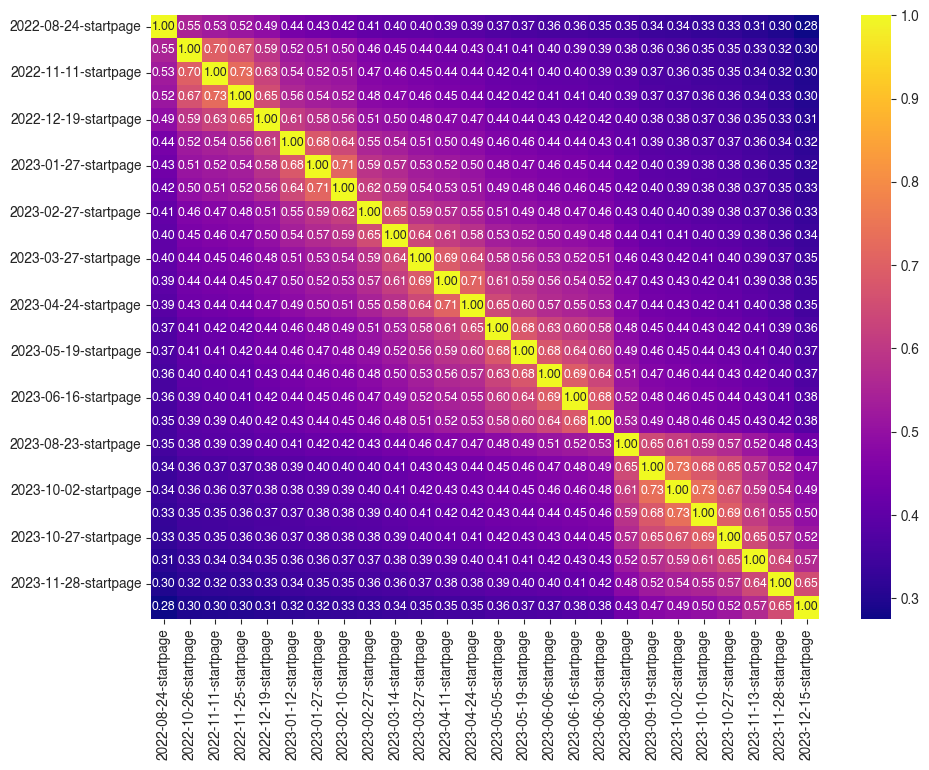

## Overlap @ 20 (Gradient)

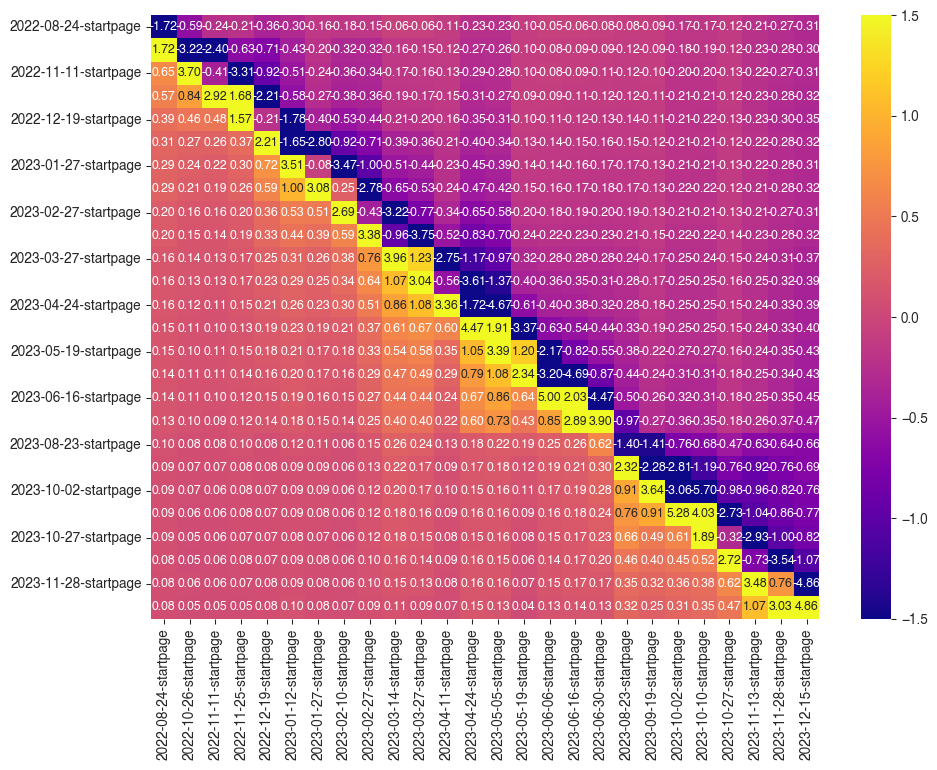

## Kendall's τ @ 20

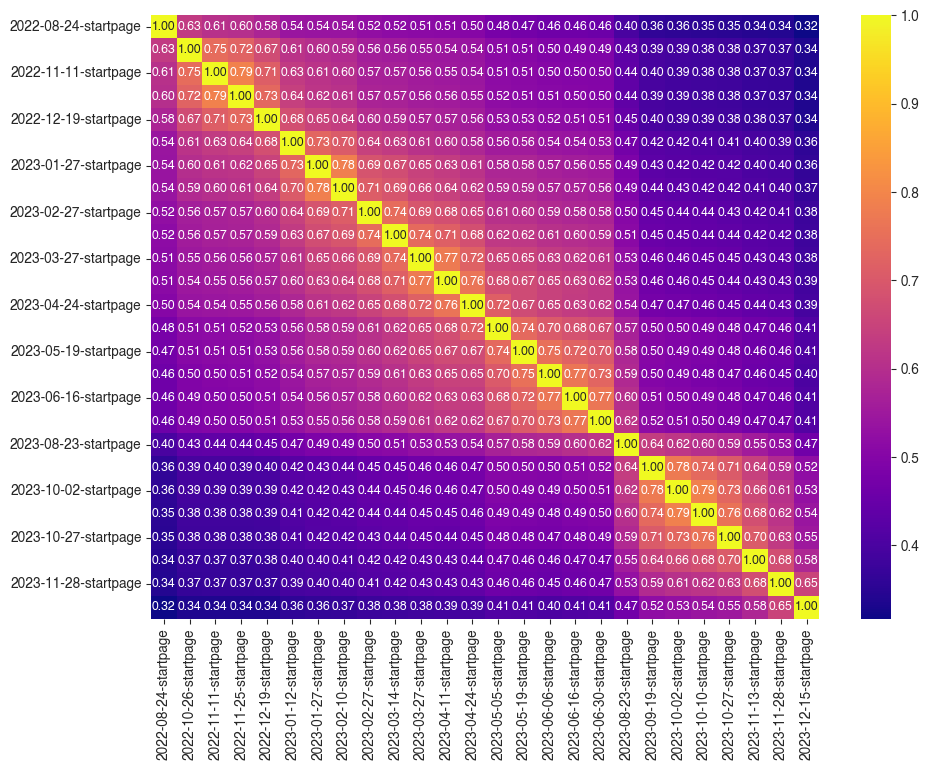

## Spearman's ρ @ 20

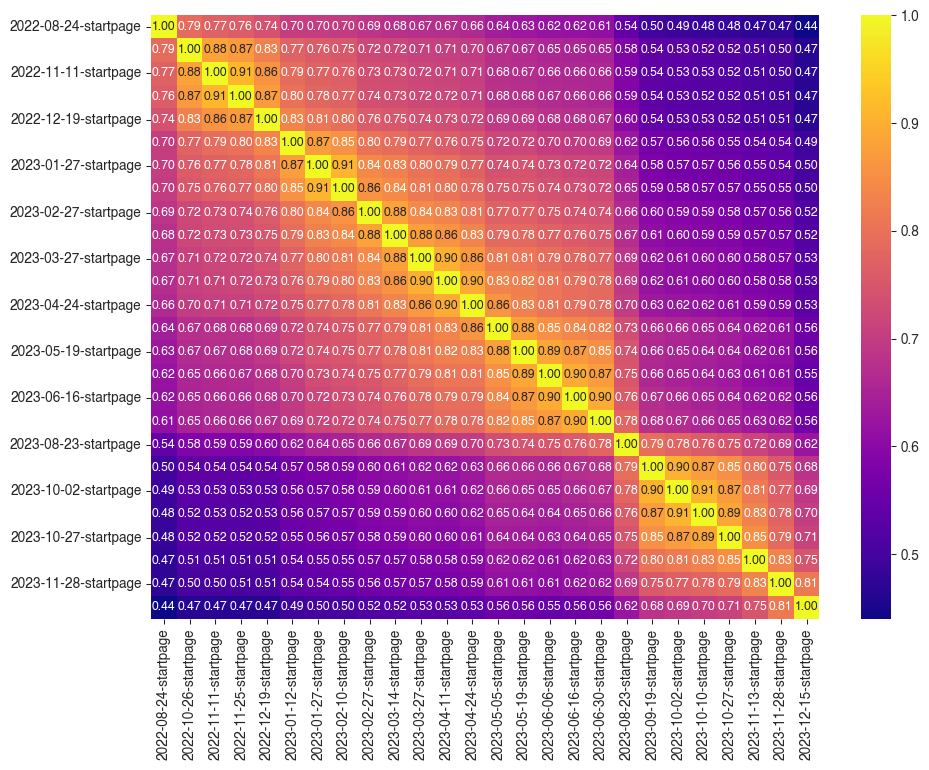

In [34]:
from datetime import datetime
from IPython.display import Markdown

RANK_CORR_CRAWLS_STARTPAGE = [r for r in RANK_CORR_CRAWLS if r.endswith('-startpage')]

overlap_matrix = pd.DataFrame(1, index=RANK_CORR_CRAWLS_STARTPAGE, columns=RANK_CORR_CRAWLS_STARTPAGE)

for idx1, idx2 in itertools.combinations(RANK_CORR_CRAWLS_STARTPAGE, 2):
    overlap = ~r_combined.isna().filter([idx1, idx2])
    overlap = overlap[overlap[idx1] | overlap[idx2]]
    overlap = len(overlap[overlap[idx1] & overlap[idx2]]) / len(overlap)
    overlap_matrix.loc[idx1, idx2] = overlap
    overlap_matrix.loc[idx2, idx1] = overlap

overlap_timestamps = np.fromiter((datetime(*map(int, [ds for ds in d.split('-') if ds.isnumeric()])).timestamp()
                                  for d in overlap_matrix.columns), dtype=int)
overlap_timestamps = overlap_timestamps - np.min(overlap_timestamps)
overlap_timestamps = overlap_timestamps / np.max(overlap_timestamps) * 2

display(Markdown(f'## Filters:'))
print(f'cutoff = {RANK_CUTOFF}')
if 'affiliate_links' in rank_corr_docs[0].columns:
    print(f'idx = {{{", ".join(RANK_GROUP_COL)}}}')
    print(f'links = [{RANK_MIN_AFFILIATE_LINKS}, {RANK_MAX_AFFILIATE_LINKS}]:')
    print(f'words >= {RANK_MIN_WORDS}:')

display(Markdown(f'## Overlap @ {RANK_CUTOFF}'))
sns.heatmap(overlap_matrix, annot=True, fmt='.2f', cmap='plasma', annot_kws={'size': 9})
plt.gcf().set_size_inches(11, 8)
plt.show()

display(Markdown(f'## Overlap @ {RANK_CUTOFF} (Gradient)'))
overlap_gradient = np.gradient(overlap_matrix, overlap_timestamps, axis=1)
overlap_gradient = pd.DataFrame(overlap_gradient, columns=overlap_matrix.columns.values, index=overlap_matrix.index.values)
sns.heatmap(overlap_gradient, annot=True, fmt='.2f', cmap='plasma', annot_kws={'size': 9}, vmin=-1.5, vmax=1.5)
plt.gcf().set_size_inches(11, 8)
plt.show()

r_combined_startpage = r_combined.loc[:, r_combined.columns.str.endswith('-startpage')]

display(Markdown(f'## Kendall\'s τ @ {RANK_CUTOFF}'))
sns.heatmap(r_combined_startpage.corr('kendall'), annot=True, fmt='.2f', cmap='plasma', annot_kws={'size': 9})
plt.gcf().set_size_inches(11, 8)
plt.show()

display(Markdown(f'## Spearman\'s ρ @ {RANK_CUTOFF}'))
sns.heatmap(r_combined_startpage.corr('spearman'), annot=True, fmt='.2f', cmap='plasma', annot_kws={'size': 9})
plt.gcf().set_size_inches(11, 8)
plt.show()

del r_combined_startpage

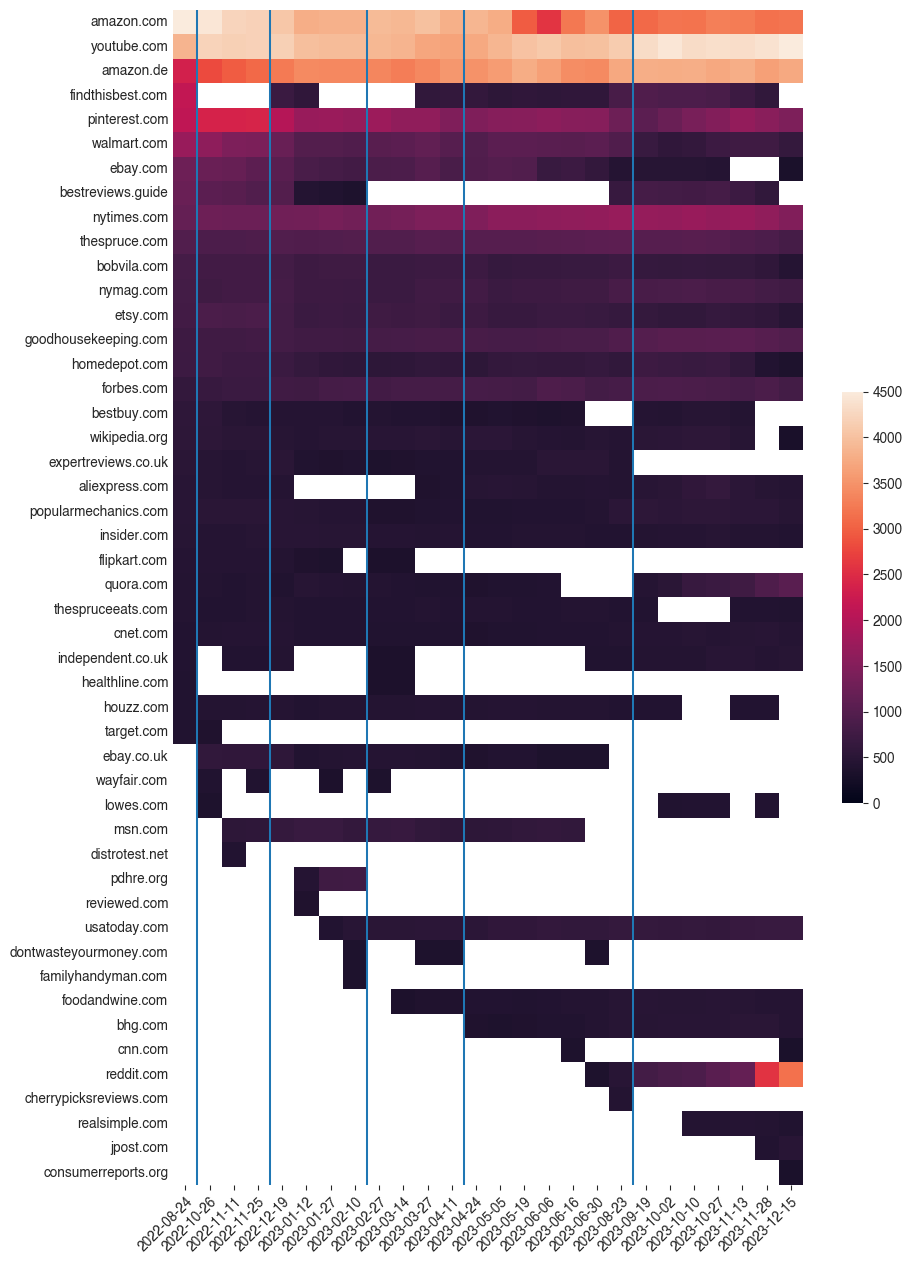

In [35]:
crawl_suffix_counts = r_combined.groupby(['public_suffix']).count()

top_suffixes = pd.DataFrame()

for c in RANK_CORR_CRAWLS_STARTPAGE:
    top_suffixes = pd.concat([top_suffixes, crawl_suffix_counts[[c]].sort_values(c, ascending=False)[:30]], axis=1)

top_suffixes.columns = [c.replace('-startpage', '') for c in top_suffixes.columns]

plt.figure(figsize=(10, 13))
ax = sns.heatmap(top_suffixes, cbar_kws={"shrink": 0.35, 'location': 'right'}, vmin=0, vmax=4500)
ax.vlines([1, 4, 8, 12, 19], 0, 100)
plt.ylabel('')
plt.tick_params(axis='y', which='both', length=0)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.savefig('resources/startpage-crawl-domains.pdf')

In [56]:
from functools import partial
import multiprocessing

def bootstrap_df(df: pd.DataFrame, k=1000, n=5000):
    df = df.dropna().select_dtypes(include=['number', 'bool'])
    if len(df) == 0:
        return pd.Series(dtype=float), [pd.DataFrame(dtype=float), pd.DataFrame(dtype=float)]
    
    samples = []
    for _ in range(n):
        samples.append(df.sample(max(3, min(k, len(df) // 2)), replace=True).mean())
    samples = pd.DataFrame(samples)
    m = samples.median()
    q = samples.quantile([.025, .975])
    return m, [m - q.loc[0.025], q.loc[0.975] - m]

def _proc_bootstrap(g, k, n):
    m, ci = bootstrap_df(g[1], k, n)
    return m, ci[0], ci[1]

def bootstrap_groupby(grp, k=1000, n=5000):
    with multiprocessing.Pool() as pool:
        means, cil, cih = zip(*pool.map(partial(_proc_bootstrap, k=k, n=n), grp))
    return pd.DataFrame(means), [pd.DataFrame(cil), pd.DataFrame(cih)]

In [37]:
es_client = Elasticsearch(**get_config()['elasticsearch'])
rank_corr_docs_stats = {}
for crawl in RANK_CORR_CRAWLS:
    idx = 'affiliate_se_stats_' + crawl.replace('-', '_')
    docs = []
    if not es_client.indices.exists(index=idx):
        continue
    for doc in tqdm(es_helpers.scan(es_client, index=idx), desc='Reading metadata', unit=' docs'):
        if not doc['_source']['query']:
            continue
        q = 'q-' + hashlib.md5(doc['_source']['query'].encode()).hexdigest()
        r = int(doc['_id'].split(':')[1])
        if r >= RANK_CUTOFF:
            continue
        docs.append({'query': q, 'rank': r, **{k: v for k, v in doc['_source'].items()
                                               if (k == 'url' or type(v) in [int, float, bool]) and not k.startswith('affiliate_links_')}})
    rank_corr_docs_stats[crawl] = pd.DataFrame(docs)

Reading metadata: 129792 docs [00:21, 6005.02 docs/s]
Reading metadata: 129730 docs [00:23, 5445.80 docs/s]
Reading metadata: 184529 docs [00:30, 6148.97 docs/s]
Reading metadata: 129212 docs [00:22, 5853.81 docs/s]
Reading metadata: 128630 docs [00:21, 5868.82 docs/s]
Reading metadata: 128045 docs [00:21, 5948.77 docs/s]
Reading metadata: 128913 docs [00:21, 5880.85 docs/s]
Reading metadata: 193621 docs [00:30, 6341.17 docs/s]
Reading metadata: 168873 docs [00:27, 6105.94 docs/s]
Reading metadata: 129546 docs [00:21, 5997.77 docs/s]
Reading metadata: 196476 docs [00:32, 6086.21 docs/s]
Reading metadata: 129206 docs [00:21, 6110.26 docs/s]
Reading metadata: 128961 docs [00:20, 6144.05 docs/s]
Reading metadata: 129128 docs [00:21, 6065.61 docs/s]
Reading metadata: 186025 docs [00:24, 7581.17 docs/s]
Reading metadata: 129784 docs [00:21, 5900.59 docs/s]
Reading metadata: 185011 docs [00:25, 7287.56 docs/s]
Reading metadata: 130146 docs [00:22, 5798.58 docs/s]
Reading metadata: 182590 doc

In [38]:
es_client = Elasticsearch(**get_config()['elasticsearch'])
rank_corr_docs_stats_chatnoir = {}

idx = 'affiliate_se_stats_clueweb22_chatnoir'
docs_chatnoir = []
for doc in tqdm(es_helpers.scan(es_client, index=idx), desc='Reading metadata', unit=' docs'):
    q = 'q-' + hashlib.md5(doc['_source']['query'].encode()).hexdigest()
    r = int(doc['_id'].split(':')[1])
    if r >= RANK_CUTOFF:
        continue
    docs_chatnoir.append({'query': q, 'rank': r, **{k: v for k, v in doc['_source'].items()
                                           if (k == 'url' or type(v) in [int, float, bool]) and not k.startswith('affiliate_links_')}})
rank_corr_docs_stats_chatnoir = pd.DataFrame(docs_chatnoir)

Reading metadata: 181875 docs [00:26, 6748.67 docs/s]


spearman    spearman_p   pearson     pearson_p  \
2023-03-14-startpage -0.998496  3.713628e-24 -0.991064  3.340841e-17   
2023-05-19-startpage -0.998496  3.713628e-24 -0.994567  3.842639e-19   
2023-06-06-startpage -0.996992  1.891102e-21 -0.995360  9.310833e-20   
2023-02-10-startpage -0.996992  1.891102e-21 -0.990530  5.619176e-17   
2023-03-27-startpage -0.995489  7.230721e-20 -0.988589  2.990272e-16   
2022-11-25-startpage -0.995489  7.230721e-20 -0.985075  3.306662e-15   
2023-04-24-startpage -0.995489  7.230721e-20 -0.992535  6.656670e-18   
2023-04-11-startpage -0.995489  7.230721e-20 -0.990544  5.547651e-17   
2023-02-27-startpage -0.995489  7.230721e-20 -0.989447  1.483361e-16   
2022-08-24-startpage -0.993985  9.577981e-19 -0.976388  1.988770e-13   
2022-10-26-startpage -0.992481  7.097516e-18 -0.979093  6.720669e-14   
2023-01-12-startpage -0.992481  7.097516e-18 -0.987155  8.631003e-16   
2023-05-05-startpage -0.992481  7.097516e-18 -0.989348  1.612896e-16   
2022-12-19-startpage -0.990977  3.642322e-17 -0.986397  1.442023e-15   
2023-06-16-startpage -0.990977  3.642322e-17 -0.992090  1.119068e-17   
2023-01-27-startpage -0.989474  1.450570e-16 -0.987917  4.990331e-16   
2022-11-11-startpage -0.987970  4.798484e-16 -0.983011  1.053174e-14   
2023-08-23-startpage -0.978947  7.148944e-14 -0.973661  5.266552e-13   
2023-09-19-startpage -0.906767  3.589233e-08 -0.916692  1.352592e-08   

                      reg_coef        R2  
2023-03-14-startpage -0.196376  0.981885  
2023-05-19-startpage -0.188080  0.989044  
2023-06-06-startpage -0.187379  0.990655  
2023-02-10-startpage -0.197274  0.980788  
2023-03-27-startpage -0.189887  0.976781  
2022-11-25-startpage -0.194717  0.969468  
2023-04-24-startpage -0.186756  0.984901  
2023-04-11-startpage -0.191856  0.980816  
2023-02-27-startpage -0.202642  0.978556  
2022-08-24-startpage -0.181462  0.951050  
2022-10-26-startpage -0.179015  0.956836  
2023-01-12-startpage -0.197423  0.973806  
2023-05-05-startpage -0.184721  0.978351  
2022-12-19-startpage -0.202501  0.972228  
2023-06-16-startpage -0.182496  0.983990  
2023-01-27-startpage -0.197214  0.975389  
2022-11-11-startpage -0.201023  0.965135  
2023-08-23-startpage -0.109020  0.945165  
2023-09-19-startpage -0.065590  0.809983

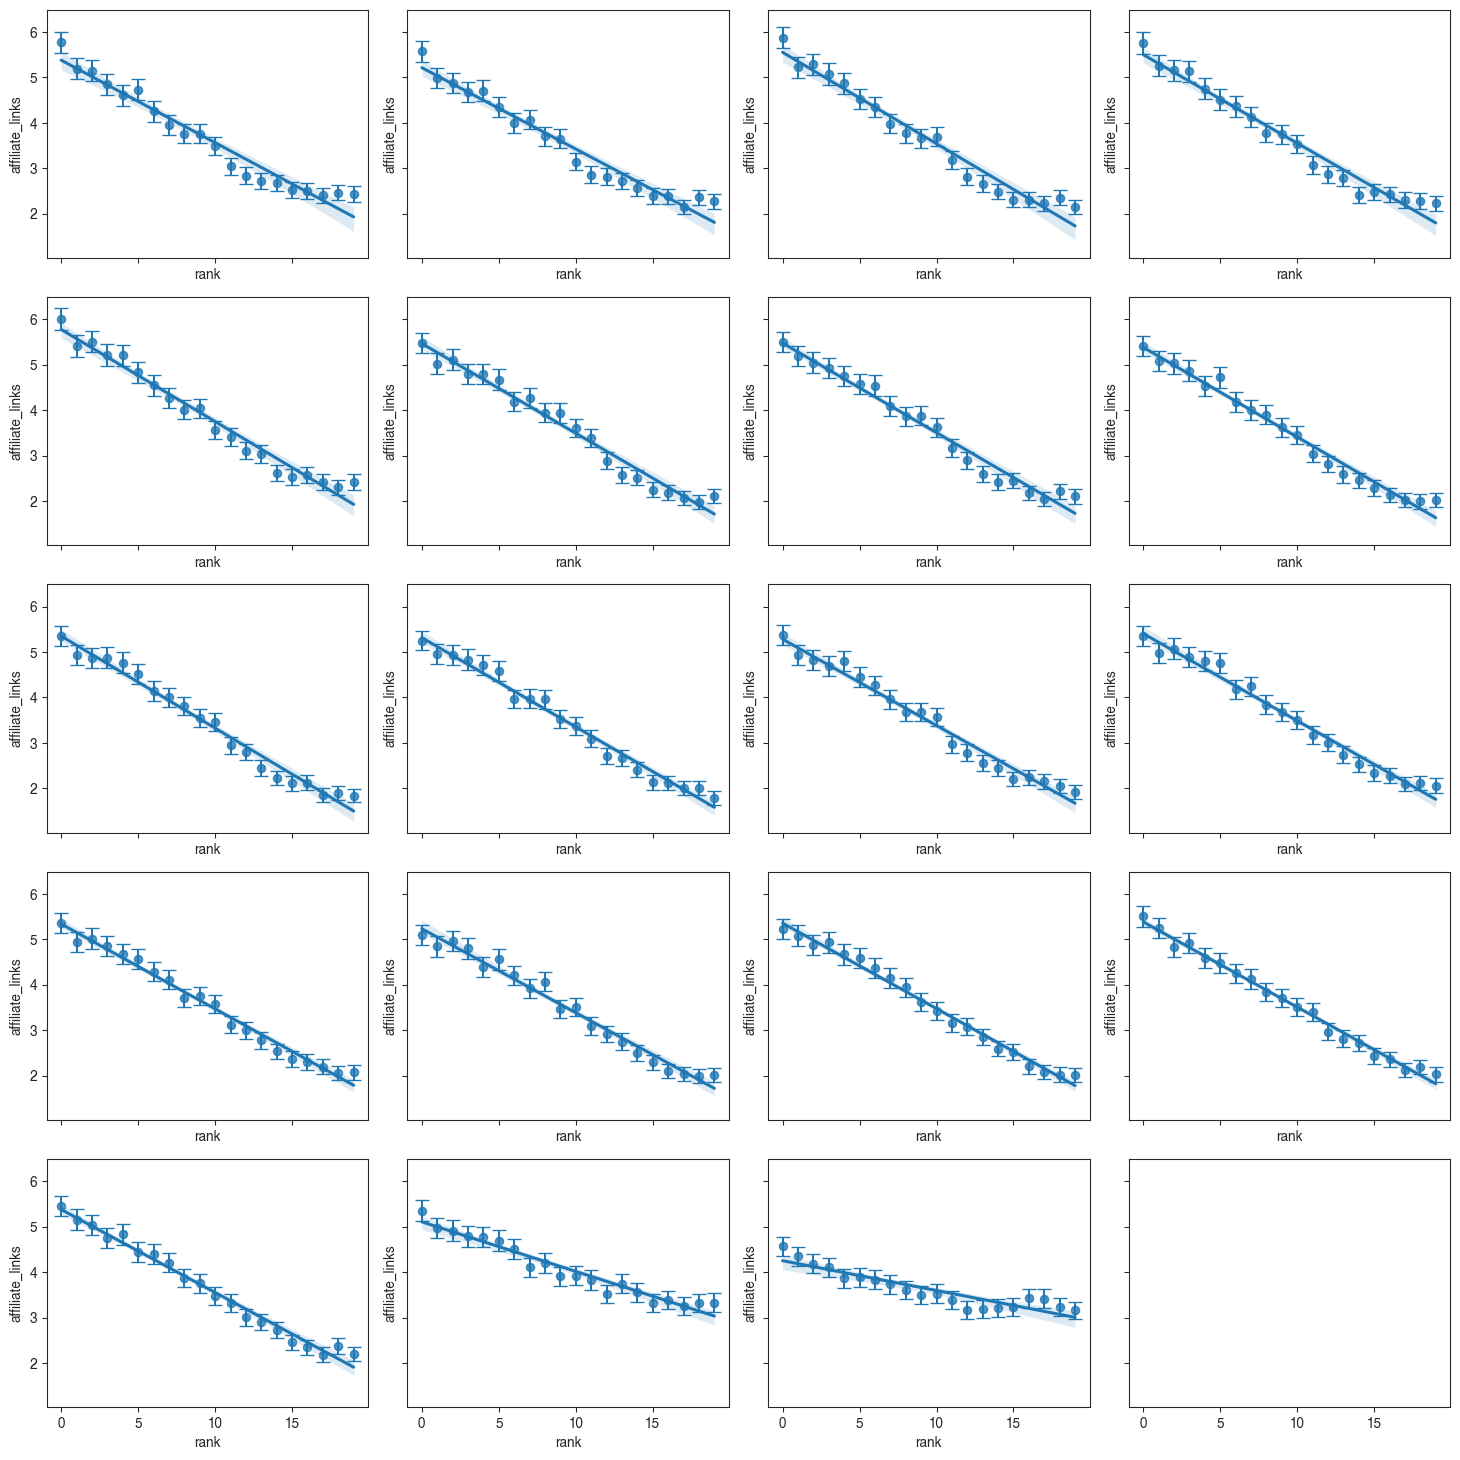

In [48]:
n_cols = 4
rank_corr_docs_stats_startpage = {k: v for k, v in rank_corr_docs_stats.items() if k.endswith('-startpage')}

n_rows = math.ceil(len(rank_corr_docs_stats_startpage) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15), sharey=True, sharex=True)
corr = pd.DataFrame(columns=['spearman', 'spearman_p', 'pearson', 'pearson_p', 'reg_coef', 'R2'])

for i, k in enumerate(rank_corr_docs_stats_startpage):
    x = 'rank'
    y = 'affiliate_links'
    g = rank_corr_docs_stats_startpage[k].query('affiliate_links < 40').groupby(x, as_index=False)

    m = g.mean(numeric_only=True)
    ci = 1.96 * g.sem(numeric_only=True)
    cil, cih = ci, ci
    # m, (cil, cih) = bootstrap_groupby(g)

    ax = sns.regplot(m, x=x, y=y, label=k, ax=axes[i // n_cols][i % n_cols])
    ax.errorbar(m[x], m[y], yerr=[cil[y], cih[y]], fmt='none', capsize=5, zorder=1, color='C0')
    linreg = stat.linregress(m[x].values, m[y].values)
    corr.loc[k] = [
        stat.spearmanr(m[x].values, m[y].values).statistic,
        stat.spearmanr(m[x].values, m[y].values).pvalue,
        stat.pearsonr(m[x].values, m[y].values).statistic,
        stat.pearsonr(m[x].values, m[y].values).pvalue,
        linreg.slope,
        r2_score(m[x].values * linreg.slope + linreg.intercept, m[y].values)
    ]

display(corr.sort_values('spearman', ascending=False, key=abs))
plt.tight_layout()
plt.savefig('resources/feature-correlations-rank-startpage-over-time.pdf')

del rank_corr_docs_stats_startpage

spearman    spearman-p   pearson     pearson-p  \
a_fwr                       -1.000000  0.000000e+00 -0.946458  2.825668e-10   
affiliate_anchor_words_mean -1.000000  0.000000e+00 -0.993095  3.305584e-18   
nofollow_links              -1.000000  0.000000e+00 -0.973399  5.752568e-13   
meta_ttr                    -1.000000  0.000000e+00 -0.989938  9.677245e-17   
is_review                   -1.000000  0.000000e+00 -0.983791  6.915205e-15   
heading_keyword_overlap      1.000000  0.000000e+00  0.978415  8.934943e-14   
h1_ttr                      -1.000000  0.000000e+00 -0.994567  3.841859e-19   
h1_fwr                      -1.000000  0.000000e+00 -0.995072  1.599254e-19   
flesch_grade                -1.000000  0.000000e+00 -0.982065  1.709260e-14   
flesch_ease                  0.998496  3.713628e-24  0.938514  9.531561e-10   
ph_ratio                    -0.998496  3.713628e-24 -0.988444  3.346219e-16   
num_words                   -0.998496  3.713628e-24 -0.977889  1.107266e-13   
num_chars                   -0.998496  3.713628e-24 -0.977487  1.300526e-13   
img_ttr                     -0.998496  3.713628e-24 -0.954943  6.170330e-11   
affiliate_nofollow_links    -0.998496  3.713628e-24 -0.990587  5.324450e-17   
affiliate_product_links     -0.998496  3.713628e-24 -0.992178  1.012426e-17   
affiliate_links             -0.998496  3.713628e-24 -0.992966  3.904839e-18   
affiliate_anchor_chars_mean -0.998496  3.713628e-24 -0.993504  1.911979e-18   
a_ttr                       -0.996992  1.891102e-21 -0.963025  1.072649e-11   
h1_num_words                -0.993985  9.577981e-19 -0.994347  5.488030e-19   
img_fwr                     -0.993985  9.577981e-19 -0.987506  6.735573e-16   
fwr                         -0.993985  9.577981e-19 -0.985669  2.299281e-15   
img_num_words               -0.993985  9.577981e-19 -0.897756  7.960314e-08   
img_num_chars               -0.987970  4.798484e-16 -0.892856  1.190887e-07   
num_ldjson                   0.987970  4.798484e-16  0.960477  1.935872e-11   
num_meta_keywords            0.986466  1.377568e-15  0.982081  1.695549e-14   
url_path_depth              -0.986466  1.377568e-15 -0.917474  1.246144e-08   
num_h2                      -0.984962  3.536432e-15 -0.962097  1.336076e-11   
h1_num_chars                -0.978947  7.148944e-14 -0.953923  7.519427e-11   
meta_fwr                    -0.962406  1.242703e-11 -0.962459  1.227243e-11   
num_h1                       0.924812  5.539165e-09  0.903837  4.690207e-08   
anchor_chars_ratio           0.918797  1.082773e-08  0.925725  4.979188e-09   
anchor_chars_mean            0.905263  4.121874e-08  0.895864  9.322071e-08   
a_num_chars                  0.905263  4.121874e-08  0.895864  9.322071e-08   
anchor_words_mean           -0.900752  6.159925e-08 -0.872087  5.423322e-07   
a_num_words                 -0.881203  2.886085e-07 -0.841404  3.339317e-06   
url_path_digits             -0.855639  1.512965e-06 -0.746135  1.583535e-04   
has_bread                    0.852200  1.845549e-06  0.879015  3.373127e-07   
self_link_ratio              0.824060  7.946551e-06  0.841715  3.284871e-06   
url_path_chars               0.682707  9.099086e-04  0.731036  2.506057e-04   
url_hyphen_path_ratio       -0.618045  3.681419e-03 -0.664360  1.398326e-03   
self_links                   0.542857  1.338721e-02  0.546646  1.263041e-02   
ttr                          0.500752  2.451927e-02  0.585456  6.687191e-03   
anchor_words_ratio           0.493233  2.711420e-02  0.504412  2.332936e-02   
meta_num_chars               0.488722  2.877203e-02  0.625009  3.213435e-03   
num_img                     -0.460150  4.120072e-02 -0.639252  2.408868e-03   
meta_keyword_overlap        -0.165414  4.858377e-01 -0.282645  2.272588e-01   
title_chars                  0.126316  5.956535e-01  0.140034  5.559669e-01   
src_offset                   0.123308  6.045088e-01 -0.135564  5.687696e-01   
meta_num_words              -0.081203  7.336076e-01  0.123872  6.028449e-01   


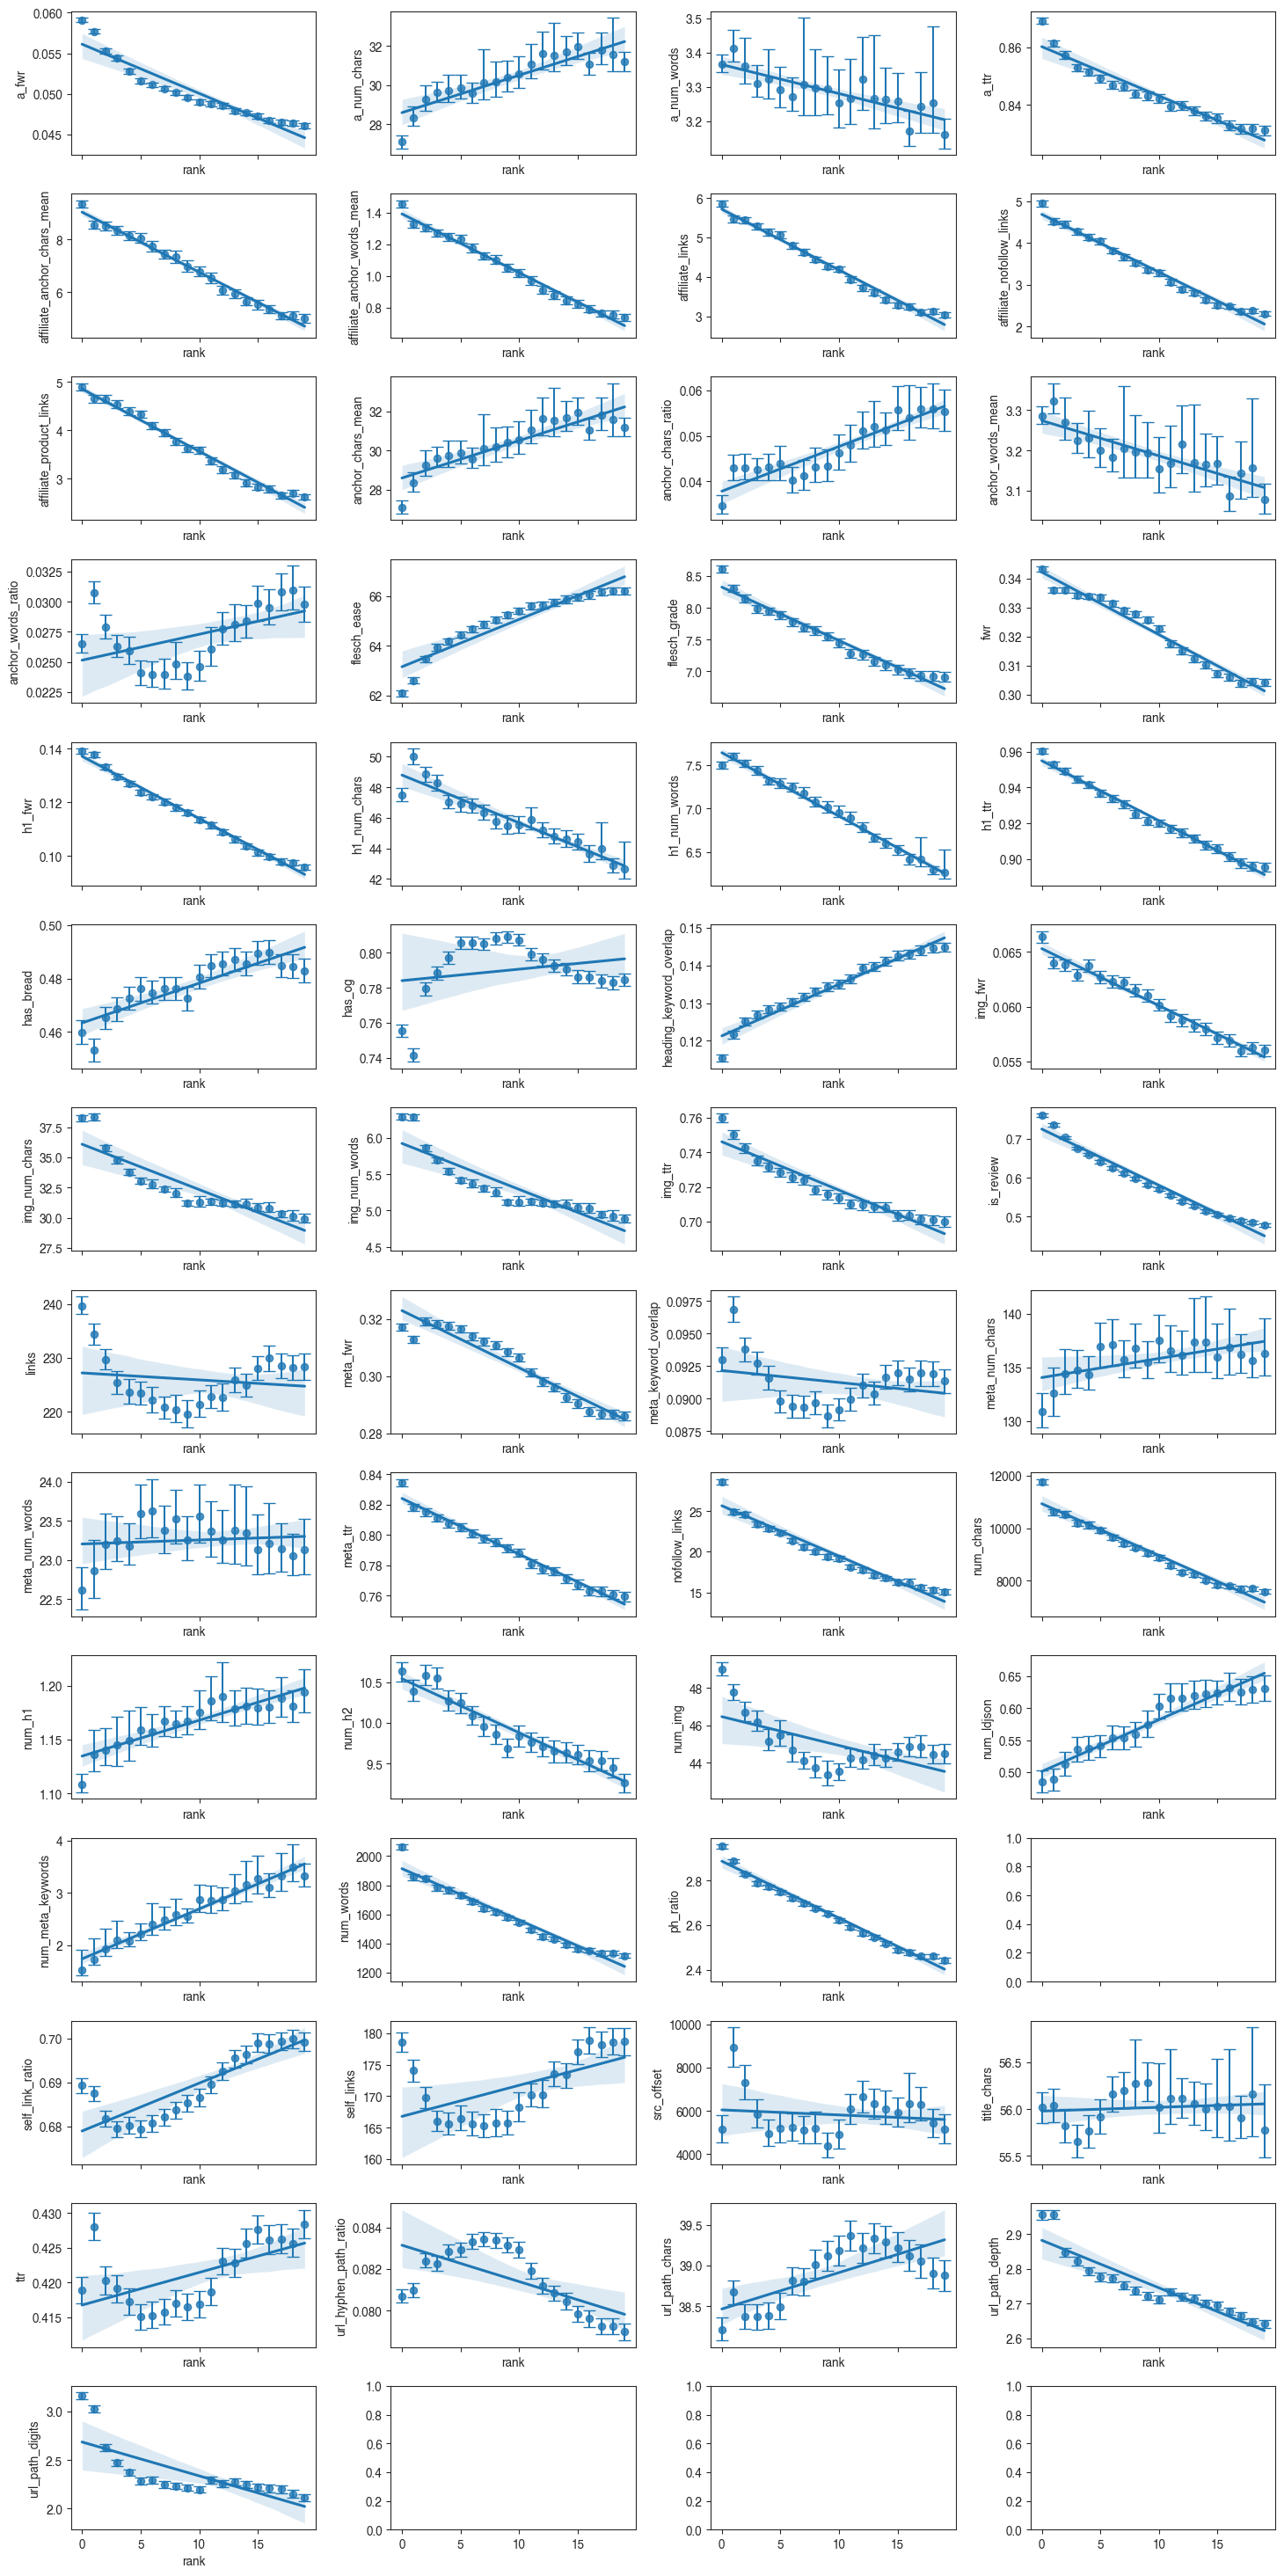

In [70]:
x = 'rank'
rank_mean_features_pre = pd.concat(rank_corr_docs_stats.values()).select_dtypes(include=['number', 'bool']).query('affiliate_links < 40')
g = rank_mean_features_pre.groupby(x, as_index=False)

# Confidence interval: Normal distribution
# suffix = 'normal-dist'
# rank_mean_features = g.mean(numeric_only=True)
# rank_mean_features_ci = 1.96 * g.sem(numeric_only=True)
# rank_mean_features_ci = [rank_mean_features_ci, rank_mean_features_ci]

# Confidence interval: Bootstrapping
suffix = 'bootstrap'
rank_mean_features, rank_mean_features_ci = bootstrap_groupby(g, k=50000, n=4000)

# IQR
# suffix = 'iqr'
# rank_mean_features = g.median(numeric_only=True)
# rank_mean_features_ci = [rank_mean_features - g.quantile(0.25, numeric_only=True), g.quantile(0.75, numeric_only=True) - rank_mean_features]

n_cols = 4
n_rows = math.ceil(len(rank_mean_features.columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 30), sharex=True)
corr = pd.DataFrame(columns=['spearman', 'spearman-p', 'pearson', 'pearson-p', 'R2'])

for i, y in enumerate(sorted(rank_mean_features.columns)):
    if x == y:
        continue
    ax = sns.regplot(rank_mean_features, x=x, y=y, label=y, ax=axes[i // n_cols][i % n_cols])
    ax.errorbar(rank_mean_features[x], rank_mean_features[y], yerr=[rank_mean_features_ci[0][y], rank_mean_features_ci[1][y]],
                fmt='none', capsize=5, zorder=1, color='C0')

    linreg = stat.linregress(rank_mean_features[x], rank_mean_features[y])
    corr.loc[y] = [
        stat.spearmanr(rank_mean_features[x], rank_mean_features[y]).statistic,
        stat.spearmanr(rank_mean_features[x], rank_mean_features[y]).pvalue,
        stat.pearsonr(rank_mean_features[x], rank_mean_features[y]).statistic,
        stat.pearsonr(rank_mean_features[x], rank_mean_features[y]).pvalue,
        r2_score(rank_mean_features[x] * linreg.slope + linreg.intercept, rank_mean_features[y])
    ]

corr = corr.sort_values('spearman', ascending=False, key=abs)
corr.to_excel(f'resources/feature-correlations-rank-{suffix}.xlsx')
display(corr)
plt.tight_layout()
plt.savefig(f'resources/feature-correlations-rank-{suffix}.pdf')

Calculating bins: 50it [01:27,  1.76s/it]


spearman    spearman-p   pearson     pearson-p  \
num_ldjson                   1.000000  0.000000e+00  0.987619  1.002799e-01   
num_words                   -0.971429  1.086410e-12 -0.914043  1.775043e-08   
anchor_words_mean           -0.960902  1.759049e-11 -0.962312  1.270577e-11   
num_chars                   -0.959398  2.456976e-11 -0.918114  1.164603e-08   
a_num_words                 -0.956391  4.622989e-11 -0.958894  2.740786e-11   
nofollow_links              -0.918797  1.082773e-08 -0.916450  1.387144e-08   
a_ttr                       -0.896241  9.035617e-08 -0.896982  8.494652e-08   
meta_keyword_overlap         0.869173  6.569040e-07  0.821856  8.813069e-06   
a_fwr                       -0.866165  7.968256e-07 -0.885797  2.059175e-07   
h1_ttr                      -0.858647  1.266301e-06 -0.741548  1.826421e-04   
affiliate_product_links     -0.858647  1.266301e-06 -0.808761  1.585639e-05   
affiliate_anchor_chars_mean -0.836090  4.401254e-06 -0.822989  8.358011e-06   
num_h2                      -0.812030  1.375170e-05 -0.804632  1.890972e-05   
url_path_depth              -0.800000  1.040880e-01 -0.667617  2.182009e-01   
img_ttr                     -0.783459  4.392227e-05 -0.736952  2.101099e-04   
flesch_grade                -0.752747  2.982233e-03 -0.538273  5.773917e-02   
fwr                         -0.739850  1.924103e-04 -0.748326  1.477637e-04   
affiliate_links             -0.736842  2.108078e-04 -0.697383  6.312159e-04   
url_path_digits             -0.736364  9.759536e-03 -0.825773  1.739509e-03   
ph_ratio                    -0.696241  6.499244e-04 -0.745569  1.611918e-04   
affiliate_nofollow_links    -0.694737  6.752715e-04 -0.688127  7.968459e-04   
affiliate_anchor_words_mean -0.687218  8.149369e-04 -0.757653  1.091926e-04   
meta_fwr                    -0.679699  9.782817e-04 -0.710111  4.517255e-04   
h1_num_words                -0.674725  8.117706e-03 -0.839141  1.752068e-04   
title_chars                 -0.639098  2.416579e-03 -0.731863  2.445707e-04   
img_num_words               -0.637594  2.492845e-03 -0.748472  1.470796e-04   
meta_ttr                    -0.625564  3.178355e-03 -0.659995  1.542377e-03   
img_num_chars               -0.618045  3.681419e-03 -0.718172  3.621789e-04   
h1_num_chars                -0.556391  1.084175e-02 -0.767117  7.923096e-05   
heading_keyword_overlap      0.530827  1.603544e-02  0.450995  4.595493e-02   
num_meta_keywords            0.502941  4.706314e-02  0.512172  4.253083e-02   
num_h1                      -0.500000  6.666667e-01 -0.544831  6.331878e-01   
self_links                   0.460150  4.120072e-02  0.405276  7.627493e-02   
num_img                     -0.446617  4.837283e-02 -0.505231  2.306946e-02   
h1_fwr                      -0.403008  7.809347e-02 -0.470390  3.634368e-02   
ttr                          0.400000  8.055387e-02  0.315461  1.754679e-01   
url_hyphen_path_ratio       -0.338346  1.445261e-01 -0.267756  2.537308e-01   
anchor_chars_ratio           0.278195  2.349738e-01  0.385709  9.303673e-02   
flesch_ease                 -0.272180  2.456689e-01 -0.201188  3.950165e-01   
self_link_ratio             -0.261654  2.651241e-01 -0.344352  1.370831e-01   
url_path_chars              -0.242105  3.037551e-01 -0.466646  3.806521e-02   
anchor_words_ratio          -0.213534  3.660206e-01  0.029153  9.028953e-01   
img_fwr                     -0.203008  3.906662e-01 -0.453386  4.467446e-02   
anchor_chars_mean            0.157895  5.061466e-01  0.144167  5.442468e-01   
a_num_chars                  0.157895  5.061466e-01  0.145126  5.415454e-01   
meta_num_words              -0.085714  7.193661e-01 -0.033490  8.885268e-01   
meta_num_chars              -0.079699  7.383737e-01  0.060777  7.990806e-01   
links                       -0.003008  9.899597e-01 -0.054022  8.210447e-01   

                                      R2  
num_ldjson                      0.974771  
num_words                       0.803076  
anchor_words_mean           

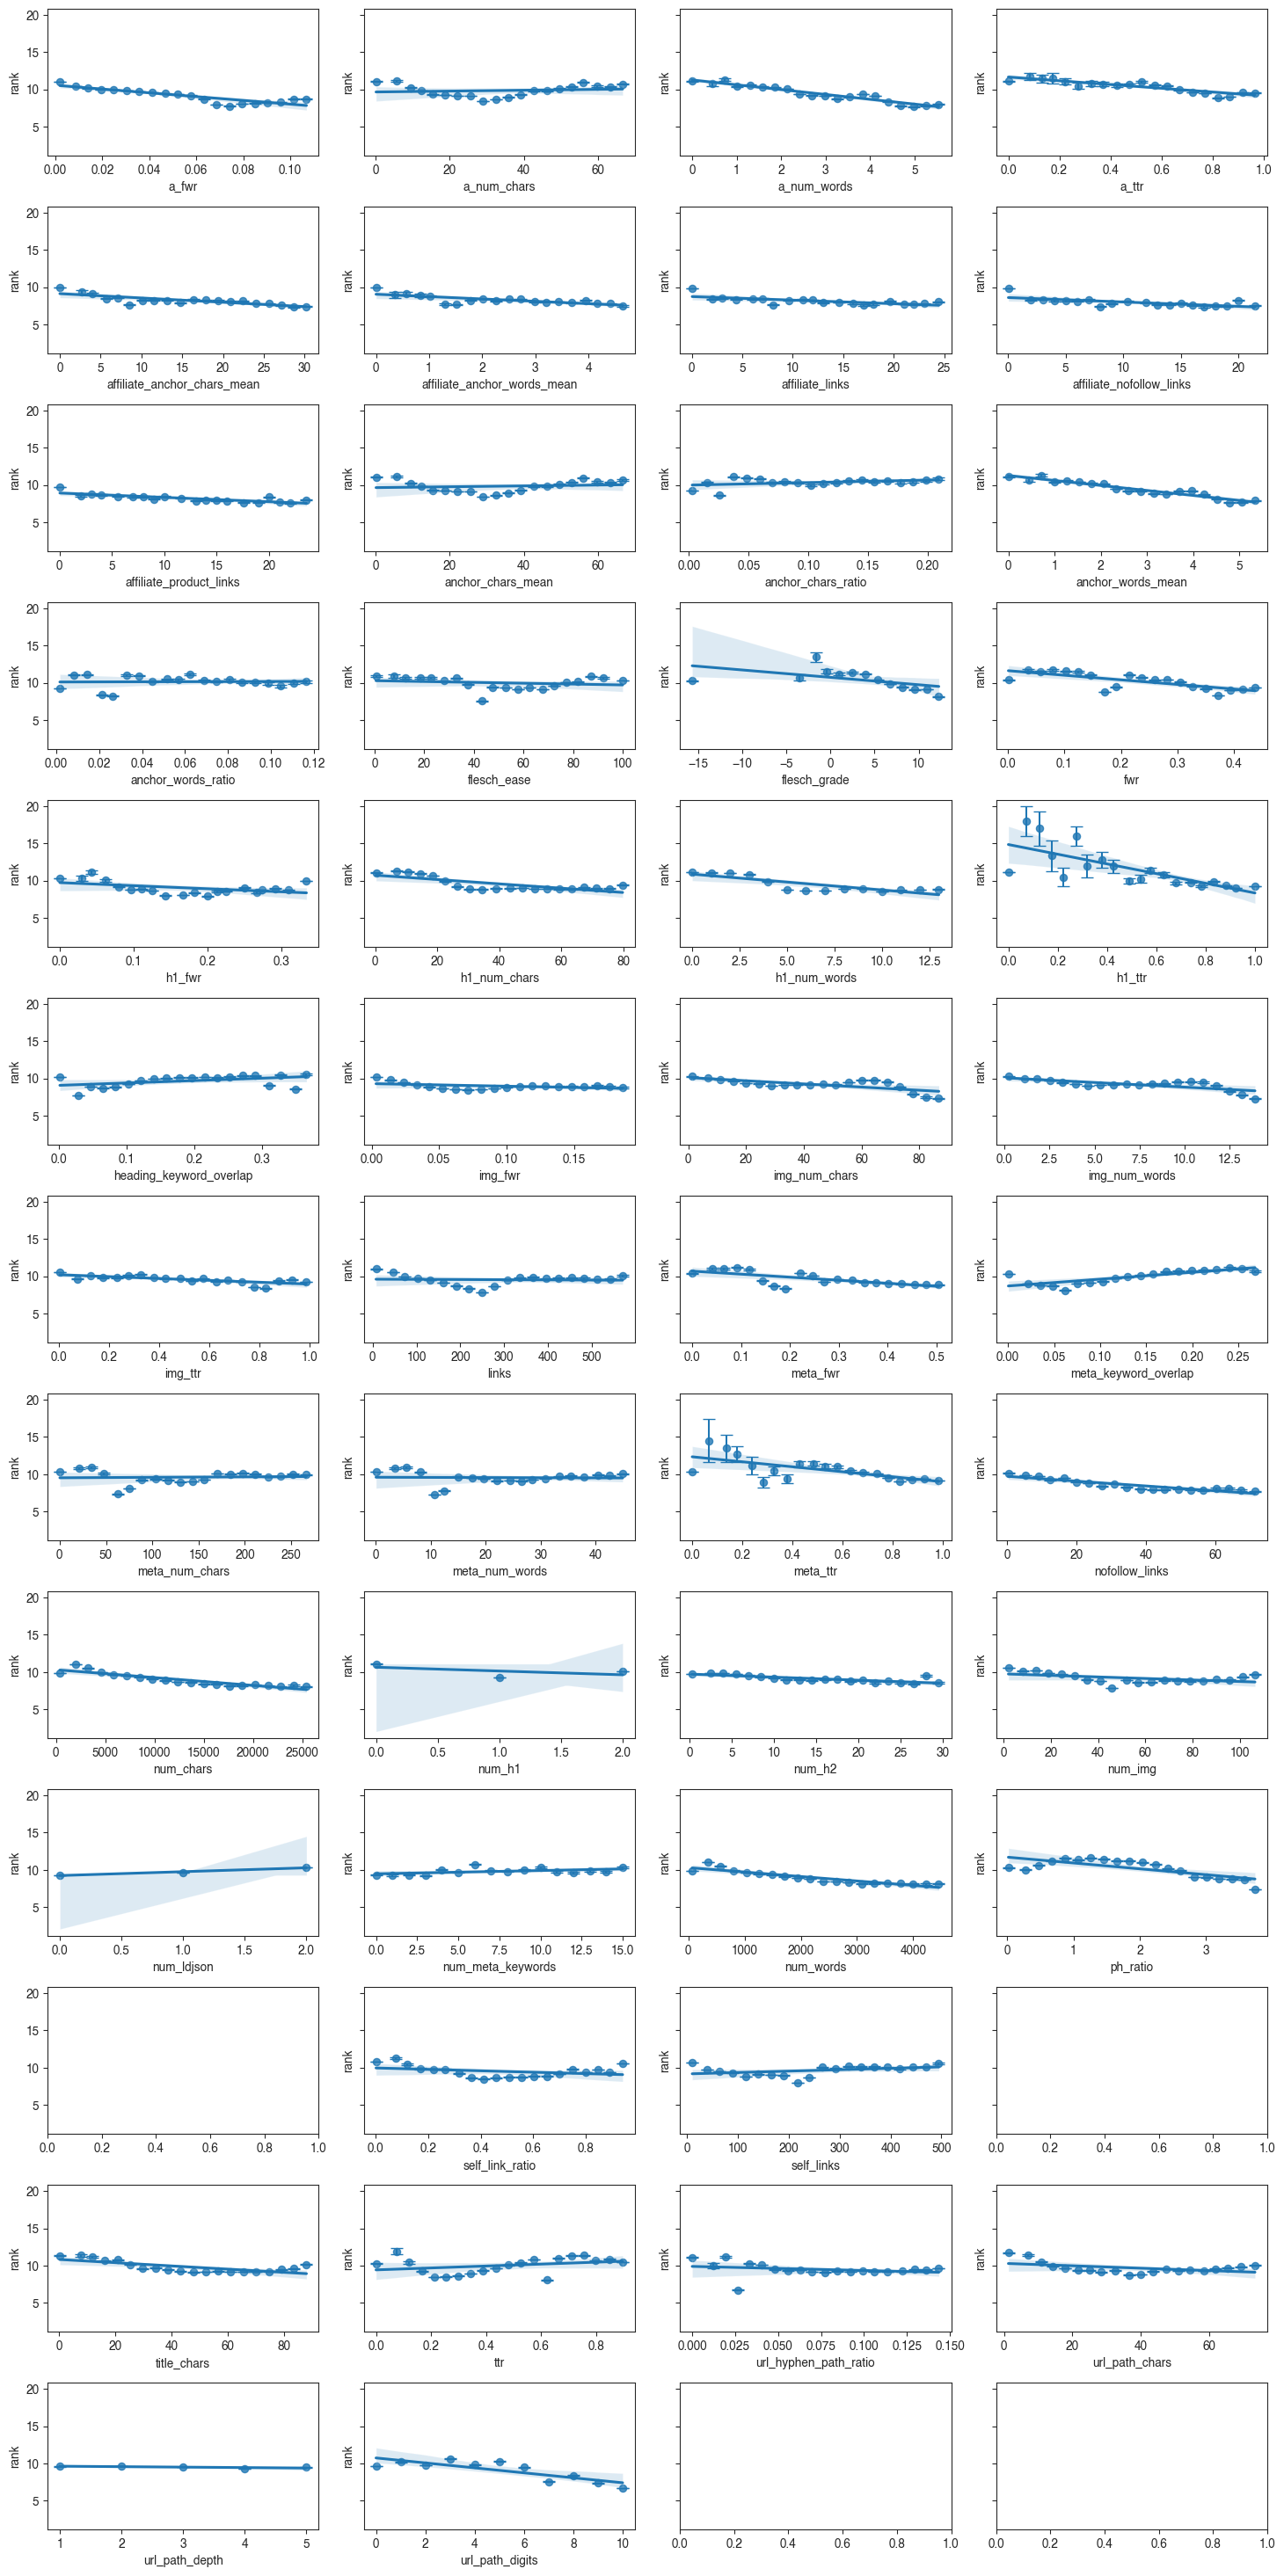

In [71]:
rank_mean_features_pre = pd.concat(rank_corr_docs_stats.values()).select_dtypes(include='number').query('affiliate_links < 40')

n_cols = 4
n_rows = math.ceil(len(rank_mean_features_pre.columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 30), sharey=True)
corr = pd.DataFrame(columns=['spearman', 'spearman-p', 'pearson', 'pearson-p', 'R2'])

y = 'rank'
for i, x in tqdm(enumerate(sorted(rank_mean_features_pre.columns)), desc='Calculating bins'):
    if x == y:
        continue
    rank_mean_features = rank_mean_features_pre[rank_mean_features_pre[x] <= rank_mean_features_pre[x].quantile(.95)]
    
    bins = pd.cut(rank_mean_features[x], bins=20)
    g = rank_mean_features.groupby(bins, as_index=False)
    
    rank_mean_features = g.mean(numeric_only=True).dropna()
    rank_mean_features_ci = 1.96 * g.sem(numeric_only=True).dropna()
    # rank_mean_features_ci = rank_mean_features_ci[~rank_mean_features.isna().any(axis=1)]
    rank_mean_features_ci = [rank_mean_features_ci, rank_mean_features_ci]
    # rank_mean_features.dropna(inplace=True)
    
    # rank_mean_features, rank_mean_features_ci = bootstrap_groupby(g, k=50000, n=4000)

    if rank_mean_features.shape[0] < 3:
        continue

    ax = sns.regplot(rank_mean_features, x=x, y=y, label=y, ax=axes[i // n_cols][i % n_cols])
    ax.errorbar(rank_mean_features[x], rank_mean_features[y], yerr=[rank_mean_features_ci[0][y], rank_mean_features_ci[1][y]],
                fmt='none', capsize=5, zorder=1, color='C0')
    
    linreg = stat.linregress(rank_mean_features[x].values, rank_mean_features[y].values)
    corr.loc[x] = [
        stat.spearmanr(rank_mean_features[x].values, rank_mean_features[y].values).statistic,
        stat.spearmanr(rank_mean_features[x].values, rank_mean_features[y].values).pvalue,
        stat.pearsonr(rank_mean_features[x].values, rank_mean_features[y].values).statistic,
        stat.pearsonr(rank_mean_features[x].values, rank_mean_features[y].values).pvalue,
        r2_score(rank_mean_features[x].values * linreg.slope + linreg.intercept, rank_mean_features[y].values)
    ]

corr = corr.sort_values('spearman', ascending=False, key=abs)
corr.to_excel('resources/feature-correlations-rank-dependent.xlsx')
# plt.ylim([-3, rank_mean_features_pre['rank'].max() + 3])
display(corr)
plt.tight_layout()
plt.savefig('resources/feature-correlations-rank-dependent.pdf')

In [52]:
# review_urls_sample = pd.DataFrame()
# non_review_urls_sample = pd.DataFrame()
# 
# for k in rank_corr_docs_stats:
#     s = rank_corr_docs_stats[k]
#     review_urls_sample = pd.concat((review_urls_sample, s[s['is_review'] == 1].sample(100)))
#     non_review_urls_sample = pd.concat((non_review_urls_sample, s[s['is_review'] == 0].sample(100)))
# 
# review_urls_sample = review_urls_sample.sample(100)[['url', 'is_review']]
# non_review_urls_sample = non_review_urls_sample.sample(100)[['url', 'is_review']]
# review_non_review_urls_sample = pd.concat((review_urls_sample, non_review_urls_sample))
# del review_urls_sample, non_review_urls_sample
# 
# review_non_review_urls_sample.reset_index(inplace=True, drop=True)
# review_non_review_urls_sample['is_review'] = review_non_review_urls_sample['is_review'].astype(int)
# review_non_review_urls_sample.sample(frac=1).to_csv('resources/reviews-non-reviews-classification.csv', index=None)

In [55]:
reviews_non_reviews_truth = pd.read_csv('resources/reviews-non-reviews-annotated-2.csv').set_index('url')
reviews_non_reviews_labels = pd.read_csv('resources/reviews-non-reviews-classification.csv').set_index('url')

acc = accuracy_score(reviews_non_reviews_truth['is_review'], reviews_non_reviews_labels['is_review'])
f1 = f1_score(reviews_non_reviews_truth['is_review'], reviews_non_reviews_labels['is_review'])
prec = precision_score(reviews_non_reviews_truth['is_review'], reviews_non_reviews_labels['is_review'])
rec = recall_score(reviews_non_reviews_truth['is_review'], reviews_non_reviews_labels['is_review'])

print('Review classification (balanced sample):')
print(f'Acc: {acc:.2f}')
print(f'F1: {f1:.2f}')
print(f'Prec: {prec:.2f}')
print(f'Rec: {rec:.2f}')

Review classification (balanced sample):
Acc: 0.79
F1: 0.76
Prec: 0.69
Rec: 0.85
